In [58]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from collections import Counter
from operator import itemgetter
import time
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
import itertools

# magic word for producing visualizations in notebook
%matplotlib inline

### Load Data
Since the dataset is more than 1GB, I've used `c` engine instead of `python` to load data faster. In addition, there are mixed data in column 18 & 19; more specifically some `NaN` values are represented by `X` & `XX`. These values are set as `na_values`.

In [59]:
# Load data
def load_data(azdias_filepath, customers_filepath, attributes_filepath, attributes_desc_filepath):
    """
    Method for loading dataset from CSV & Excel
    
    Args:
        azdias_filepath (str): Azdias filepath (Udacity_AZDIAS_052018)
        customers_filepath (str): Customers filepath (Udacity_CUSTOMERS_052018)
        attributes_filepath (str): Attributes filepath (DIAS Attributes - Values 2017.xlsx)
        attributes_desc_filepath (str): Attributes description (DIAS Information Levels - Attributes 2017.xlsx)
        
    Output:
        azdias: Pandas Dataframe
        customers: Pandas Dataframe
        attributes: Pandas Dataframe
        attributes_desc: Pandas Dataframe
    """
    
    # Load "azdias" dataset
    azdias = pd.read_csv(azdias_filepath, na_values=["X", "XX"], engine="c")
    # Set LNR as index
    #azdias = azdias.set_index("LNR")
    
    # Load "customers" dataset
    customers = pd.read_csv(customers_filepath, na_values=["X", "XX"], engine="c")
    # Set LNT as index
    #customers = customers.set_index("LNR")
    
    # Load "attributes" dataset
    attributes = pd.read_excel(attributes_filepath, header=1).loc[:, ["Attribute", "Value", "Meaning"]].fillna(method='ffill')
    
    # Load "attributes_desc"
    attributes_desc = pd.read_excel(attributes_desc_filepath, header=1).loc[:, ["Information level", "Attribute", "Description",
                                                                                "Additional notes"]].fillna(method='ffill')
    
    return azdias, customers, attributes, attributes_desc

In [60]:
%%time
azdias_filepath = "Udacity_AZDIAS_052018.csv"
customers_filepath = "Udacity_CUSTOMERS_052018.csv"
attributes_filepath = "DIAS Attributes - Values 2017.xlsx"
attributes_desc_filepath = "DIAS Information Levels - Attributes 2017.xlsx"

azdias, customers, attributes, attributes_desc = load_data(azdias_filepath, customers_filepath, attributes_filepath,
                                                         attributes_desc_filepath)

Wall time: 47 s


### Explore the Datasets

In [61]:
print("General population dataset, azdias shape: ", azdias.shape)
print("Customers dataset, customers shape: ", customers.shape)

General population dataset, azdias shape:  (891221, 366)
Customers dataset, customers shape:  (191652, 369)


```
df1 = pd.DataFrame({'A': [None, 0], 'B': [None, 4]})
df2 = pd.DataFrame({'A': [1, 1, 5], 'B': [3, 3, 6]})
print(df1.head())
print(df2.head())
df3 = df1.combine_first(df2)
print(df3)
```

In [62]:
# Create a dataframe that describes the information about each features
def build_feat_info(df):
    """
    Method for finding feature informations
    
    Args:
        df (Pandas Dataframe): Dataframe that needs to be described
        
    Output:
        Pandas Dataframe
    """
    return pd.DataFrame({
        'value_count' : [df[x].count() for x in df.columns],
        'value_distinct' : [df[x].unique().shape[0] for x in df.columns],
        'num_nans': [df[x].isnull().sum() for x in df.columns],
        'percent_nans' : [round(df[x].isnull().sum()/df[x].shape[0], 3) for x in df.columns],
    }, index = df.columns)

In [63]:
%%time
# Statistics of azdias
feat_info_azdias = build_feat_info(azdias)
feat_info_azdias.sort_values(by=['percent_nans'], ascending=False)

Wall time: 7.95 s


,value_count,value_distinct,num_nans,percent_nans
ALTER_KIND4,1205,13,890016,0.999
ALTER_KIND3,6170,16,885051,0.993
ALTER_KIND2,29499,18,861722,0.967
ALTER_KIND1,81058,18,810163,0.909
EXTSEL992,237068,57,654153,0.734
...,...,...,...,...
D19_VERSAND_ANZ_24,891221,7,0,0.000
D19_VERSAND_DATUM,891221,10,0,0.000
D19_VERSAND_OFFLINE_DATUM,891221,10,0,0.000
D19_VERSAND_ONLINE_DATUM,891221,10,0,0.000


In [64]:
%%time
# Statistics of customers
feat_info_customers = build_feat_info(customers)
feat_info_customers.sort_values(by=['percent_nans'], ascending=False)

Wall time: 1.88 s


,value_count,value_distinct,num_nans,percent_nans
ALTER_KIND4,236,11,191416,0.999
ALTER_KIND3,1275,15,190377,0.993
ALTER_KIND2,5100,18,186552,0.973
ALTER_KIND1,11766,18,179886,0.939
KK_KUNDENTYP,79715,7,111937,0.584
...,...,...,...,...
D19_VERSAND_ANZ_24,191652,7,0,0.000
D19_VERSAND_DATUM,191652,10,0,0.000
D19_VERSAND_OFFLINE_DATUM,191652,10,0,0.000
D19_VERSAND_ONLINE_DATUM,191652,10,0,0.000


### Check Features 
#### Create Features List from `attributes` and `attributes_desc`

In [65]:
# Features listed in "attributes" 
features_attributes = sorted(list(set(attributes.Attribute.tolist())))

# Features listed in attributes_desc 
features_attributes_desc = attributes_desc.Attribute.tolist()

# Multiple features in attributes_desc are grouped in a single string separated by whitespaces
# Split the multiple features into separate string
features_attributes_desc = sorted([feature for group_feature in features_attributes_desc for feature in group_feature.split()])

# Check if there is any unique features in attributes or in attributes_desc
unique_attributes_features = set(features_attributes) - set(features_attributes_desc)
unique_attributes_desc_features = set(features_attributes_desc) - set(features_attributes)
print("Unique attributes features: {}, Unique attributes_desc features: {}".format(len(unique_attributes_features),
                                                                                  len(unique_attributes_desc_features)))

# Combine all features and create the features list
features_list = sorted(list(set.union(set(features_attributes), set(features_attributes_desc))))
print("Total number of features: ", len(features_list))

Unique attributes features: 4, Unique attributes_desc features: 8
Total number of features:  322


#### Check Features of `azdias` and `customers`
Using `features_list` generated earlier, check how many features are present in `azdias` and `customers`

In [66]:
azdias_feat = azdias.columns.tolist()
customers_feat = customers.columns.tolist()

# First check if all the features from features_list are present in azdias and customers
common_azdias_feat = set(azdias_feat) & set(features_list)
common_customers_feat = set(customers_feat) & set(features_list)

print("Number of common features: azdias_feat: {}, customers_feat: {}".format(len(common_azdias_feat),
                                                                              len(common_customers_feat)))

Number of common features: azdias_feat: 276, customers_feat: 276


**Observations:** There are 8 features in `features_list` which are present in `attributes_desc`, but not in `attributes`. These features have descriptions but their encoded values cannot be found in `attributes`. Let's explore these features and their values in `azdias` before further analysis of all the datasets.

```python
unique_attributes_desc_features = list(unique_attributes_desc_features)
azdias_subset = azdias.loc[:, unique_attributes_desc_features]
feat_info_azdias_subset = build_feat_info(azdias_subset)
feat_info_azdias_subset.sort_values(by=['percent_nans'], ascending=False)
```

**Observations:** Features with 100% `NaN` counts will be dropped during the downstream data cleaning process. However, four features: i. `ARBEIT`, ii. `D19_VERSI_DATUM`, iii. `D19_VERSI_OFFLINE_DATUM` iv. `D19_VERSI_ONLINE_DATUM`, have relatively low `NaN` counts. These features should be preserved during data cleaning process. First, let's explore the distinct values for each columns since they are not described in `attributes`.

```python
# Drop the columns with high NaN percentage from azdias_subset
azdias_subset.drop(columns=["EINWOHNER", "PLZ8", "PLZ", "GKZ"], inplace=True)
azdias_subset_distinct_val = pd.DataFrame({
                                "value_list" : [sorted(azdias_subset[x].unique()) for x in azdias_subset.columns]
                            }, index = azdias_subset.columns)
azdias_subset_distinct_val
```

**Assumption:** Referring to `DIAS Information Levels - Attributes 2017.xlsx`, `ARBEIT` belongs to community level features. Community level features also include `RELAT_AB` whose description is similar to `ARBEIT`. Therefore, value encoded for `RELAT_AB` will be used as reference for `ARBEIT`.

`D19_VERSI_DATUM`, `D19_VERSI_OFFLINE_DATUM`, and `D19_VERSI_ONLINE_DATUM` have no missing values and no encoding description is available for these features in `DIAS Attributes - Values 2017.xlsx`. Therefore, these features will remain in the datasets without any modifications.

### Data Cleaning
For some features listed in `DIAS Attributes - Values 2017.xlsx` **_unknown information_** are encoded to certain numbers. These values will be replaced with `NaN` in `azdias` and `customers` datasets.
1. Features whose information are available in `DIAS Information Levels - Attributes 2017.xlsx` or in `DIAS Attributes - Values 2017.xlsx`, will be selected for the analysis.  
2. The **_unknown information_** will be replaced with `NaN`.  
3. Both `azdias` and `customers` datasets will be compared and features with similar percentage of `NaN` count will be dropped.

In [69]:
# Select the features whose information are available
azdias = azdias.loc[:, features_list]
customers = customers.loc[:, features_list]

In [70]:
# Create a subset of "attributes" with each feature and the associated unknown values
attributes_unknown_val = attributes[(attributes['Meaning'].str.contains("unknown") | attributes['Meaning'].str.contains("no "))]

# Create a list of unknown value for each feature
unknown_val = []
for attribute in attributes_unknown_val['Attribute'].unique():
    val = attributes_unknown_val.loc[attributes['Attribute'] == attribute, 'Value'].astype("str").str.cat(sep=',').split(',')
    val = list(map(int, val)) # Convert the list to "int"
    unknown_val.append(val)
    
# Create a dataframe of features with the list unknown value
attributes_unknown_val = pd.concat([pd.Series(attributes_unknown_val['Attribute'].unique()),
                                    pd.Series(unknown_val)], axis=1)

# Rename the columns
attributes_unknown_val.columns = ['attribute', 'unknown']

# Add a row for ARBEIT and the associated unknown values
#ARBEIT_row = {"attribute" : "ARBEIT", "unknown" : 9}

# Append the row to attributes_unknown_val
attributes_unknown_val = attributes_unknown_val.append({"attribute" : "ARBEIT", "unknown" : [-1, 9]}, ignore_index=True)

In [71]:
%%time
# Replace the unknown values in azdias with NaN based on attributes_unknown_val
for row in attributes_unknown_val.itertuples(index=False):
    if row.attribute in azdias.columns.values.tolist():
        print("Replaceing unknown with NaN on: ", row.attribute)
        nan_val = attributes_unknown_val.loc[attributes_unknown_val['attribute'] == row.attribute, 'unknown'].iloc[0]
        nan_idx = azdias.loc[:, row.attribute].isin(nan_val)
        azdias.loc[nan_idx, row.attribute] = np.NaN
    else:
        continue

Replaceing unknown with NaN on:  AGER_TYP
Replaceing unknown with NaN on:  ALTERSKATEGORIE_GROB
Replaceing unknown with NaN on:  ALTER_HH
Replaceing unknown with NaN on:  ANREDE_KZ
Replaceing unknown with NaN on:  BALLRAUM
Replaceing unknown with NaN on:  BIP_FLAG
Replaceing unknown with NaN on:  CAMEO_DEUG_2015
Replaceing unknown with NaN on:  CAMEO_DEUINTL_2015
Replaceing unknown with NaN on:  CJT_GESAMTTYP
Replaceing unknown with NaN on:  D19_BANKEN_ANZ_12
Replaceing unknown with NaN on:  D19_BANKEN_ANZ_24
Replaceing unknown with NaN on:  D19_BANKEN_DATUM
Replaceing unknown with NaN on:  D19_BANKEN_DIREKT_RZ
Replaceing unknown with NaN on:  D19_BANKEN_GROSS_RZ
Replaceing unknown with NaN on:  D19_BANKEN_LOKAL_RZ
Replaceing unknown with NaN on:  D19_BANKEN_OFFLINE_DATUM
Replaceing unknown with NaN on:  D19_BANKEN_ONLINE_DATUM
Replaceing unknown with NaN on:  D19_BANKEN_ONLINE_QUOTE_12
Replaceing unknown with NaN on:  D19_BANKEN_REST_RZ
Replaceing unknown with NaN on:  D19_BEKLEIDUNG_

Replaceing unknown with NaN on:  KBA13_CCM_2000
Replaceing unknown with NaN on:  KBA13_CCM_2500
Replaceing unknown with NaN on:  KBA13_CCM_2501
Replaceing unknown with NaN on:  KBA13_CCM_3000
Replaceing unknown with NaN on:  KBA13_CCM_3001
Replaceing unknown with NaN on:  KBA13_FAB_ASIEN
Replaceing unknown with NaN on:  KBA13_FAB_SONSTIGE
Replaceing unknown with NaN on:  KBA13_FIAT
Replaceing unknown with NaN on:  KBA13_FORD
Replaceing unknown with NaN on:  KBA13_HALTER_20
Replaceing unknown with NaN on:  KBA13_HALTER_25
Replaceing unknown with NaN on:  KBA13_HALTER_30
Replaceing unknown with NaN on:  KBA13_HALTER_35
Replaceing unknown with NaN on:  KBA13_HALTER_40
Replaceing unknown with NaN on:  KBA13_HALTER_45
Replaceing unknown with NaN on:  KBA13_HALTER_50
Replaceing unknown with NaN on:  KBA13_HALTER_55
Replaceing unknown with NaN on:  KBA13_HALTER_60
Replaceing unknown with NaN on:  KBA13_HALTER_65
Replaceing unknown with NaN on:  KBA13_HALTER_66
Replaceing unknown with NaN on: 

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,SEMIO_VERT,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,WACHSTUMSGEBIET_NB,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,NaN,1.0,NaN,2.0,11.0,0.0,2.0,0.0,3.0,6.0,...,1.0,3.0,NaN,NaN,2.0,NaN,9.0,4.0,3.0,5.0
2,NaN,3.0,17.0,2.0,10.0,0.0,1.0,0.0,3.0,2.0,...,4.0,2.0,NaN,NaN,1.0,NaN,9.0,2.0,3.0,5.0
3,2.0,4.0,13.0,2.0,1.0,0.0,0.0,0.0,2.0,4.0,...,4.0,1.0,NaN,NaN,1.0,NaN,9.0,7.0,NaN,3.0
4,NaN,3.0,20.0,1.0,3.0,0.0,4.0,0.0,4.0,2.0,...,7.0,2.0,NaN,NaN,2.0,NaN,9.0,3.0,2.0,4.0


In [72]:
%%time
# Replace the unknown values in customers with NaN based on attributes_unknown_val
for row in attributes_unknown_val.itertuples(index=False):
    if row.attribute in customers.columns.values.tolist():
        print("Replaceing unknown with NaN on: ", row.attribute)
        nan_val = attributes_unknown_val.loc[attributes_unknown_val['attribute'] == row.attribute, 'unknown'].iloc[0]
        nan_idx = customers.loc[:, row.attribute].isin(nan_val)
        customers.loc[nan_idx, row.attribute] = np.NaN
    else:
        continue

Replaceing unknown with NaN on:  AGER_TYP
Replaceing unknown with NaN on:  ALTERSKATEGORIE_GROB
Replaceing unknown with NaN on:  ALTER_HH
Replaceing unknown with NaN on:  ANREDE_KZ
Replaceing unknown with NaN on:  BALLRAUM
Replaceing unknown with NaN on:  BIP_FLAG
Replaceing unknown with NaN on:  CAMEO_DEUG_2015
Replaceing unknown with NaN on:  CAMEO_DEUINTL_2015
Replaceing unknown with NaN on:  CJT_GESAMTTYP
Replaceing unknown with NaN on:  D19_BANKEN_ANZ_12
Replaceing unknown with NaN on:  D19_BANKEN_ANZ_24
Replaceing unknown with NaN on:  D19_BANKEN_DATUM
Replaceing unknown with NaN on:  D19_BANKEN_DIREKT_RZ
Replaceing unknown with NaN on:  D19_BANKEN_GROSS_RZ
Replaceing unknown with NaN on:  D19_BANKEN_LOKAL_RZ
Replaceing unknown with NaN on:  D19_BANKEN_OFFLINE_DATUM
Replaceing unknown with NaN on:  D19_BANKEN_ONLINE_DATUM
Replaceing unknown with NaN on:  D19_BANKEN_ONLINE_QUOTE_12
Replaceing unknown with NaN on:  D19_BANKEN_REST_RZ
Replaceing unknown with NaN on:  D19_BEKLEIDUNG_

Replaceing unknown with NaN on:  KBA13_CCM_2000
Replaceing unknown with NaN on:  KBA13_CCM_2500
Replaceing unknown with NaN on:  KBA13_CCM_2501
Replaceing unknown with NaN on:  KBA13_CCM_3000
Replaceing unknown with NaN on:  KBA13_CCM_3001
Replaceing unknown with NaN on:  KBA13_FAB_ASIEN
Replaceing unknown with NaN on:  KBA13_FAB_SONSTIGE
Replaceing unknown with NaN on:  KBA13_FIAT
Replaceing unknown with NaN on:  KBA13_FORD
Replaceing unknown with NaN on:  KBA13_HALTER_20
Replaceing unknown with NaN on:  KBA13_HALTER_25
Replaceing unknown with NaN on:  KBA13_HALTER_30
Replaceing unknown with NaN on:  KBA13_HALTER_35
Replaceing unknown with NaN on:  KBA13_HALTER_40
Replaceing unknown with NaN on:  KBA13_HALTER_45
Replaceing unknown with NaN on:  KBA13_HALTER_50
Replaceing unknown with NaN on:  KBA13_HALTER_55
Replaceing unknown with NaN on:  KBA13_HALTER_60
Replaceing unknown with NaN on:  KBA13_HALTER_65
Replaceing unknown with NaN on:  KBA13_HALTER_66
Replaceing unknown with NaN on: 

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,SEMIO_VERT,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,WACHSTUMSGEBIET_NB,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,2.0,4.0,10.0,1.0,1.0,0.0,2.0,0.0,1.0,3.0,...,6.0,3.0,NaN,NaN,1.0,NaN,9.0,7.0,6.0,3.0
1,NaN,4.0,11.0,1.0,NaN,NaN,3.0,0.0,NaN,NaN,...,7.0,3.0,NaN,NaN,1.0,NaN,9.0,NaN,NaN,3.0
2,NaN,4.0,6.0,2.0,1.0,0.0,1.0,0.0,3.0,7.0,...,3.0,1.0,NaN,NaN,2.0,NaN,9.0,2.0,6.0,3.0
3,1.0,4.0,8.0,1.0,0.0,NaN,0.0,0.0,1.0,7.0,...,7.0,0.0,NaN,NaN,1.0,NaN,9.0,7.0,NaN,1.0
4,NaN,3.0,20.0,1.0,7.0,0.0,4.0,0.0,3.0,3.0,...,5.0,1.0,NaN,NaN,2.0,NaN,9.0,3.0,2.0,1.0


In [86]:
# Replace zeros in GEBURTSJAHR with NaN
azdias["GEBURTSJAHR"].replace(0, np.nan, inplace=True)

```python
numerical_feat = ["ALTER_HH", "ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", "ANZ_TITEL", "GEBURTSJAHR",
                  "KBA13_ANZAHL_PKW", "MIN_GEBAEUDEJAHR"]
```

In [47]:
azdias.shape, customers.shape

((891221, 322), (191652, 322))

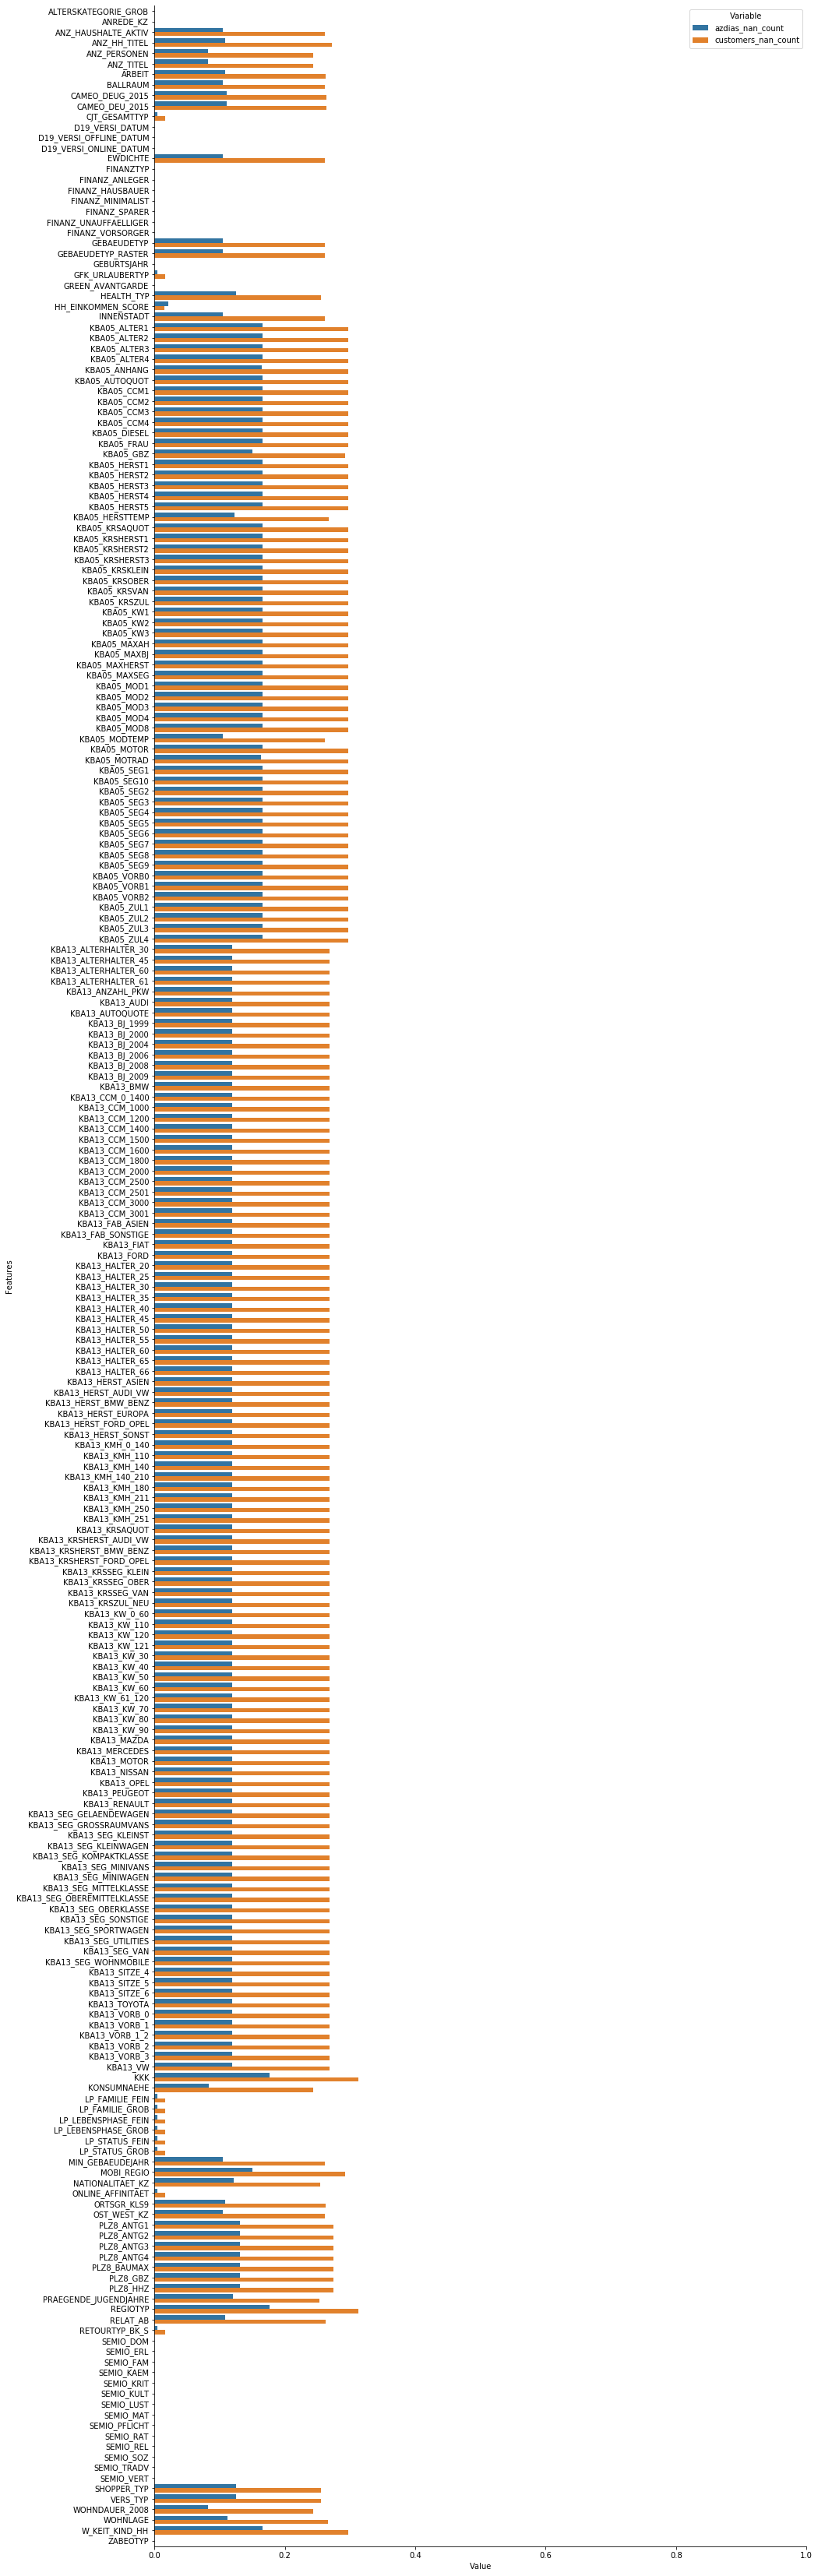

In [82]:
# Find NaN count for each features in azdias and customers dataset
# Drop features where NaN count for each features in both dataset are greater than 0.2 (20%)
feature_nan_count = pd.DataFrame({
                                'azdias_nan_count': [round(azdias[x].isnull().sum()/azdias[x].shape[0], 3) for x in azdias.columns],
                                'customers_nan_count': [round(customers[x].isnull().sum()/customers[x].shape[0], 3) for x in customers.columns]
                    }, index = azdias.columns)
feature_nan_count = feature_nan_count.loc[(feature_nan_count.azdias_nan_count <= 0.2) |
                                                 (feature_nan_count.customers_nan_count <= 0.2)]

# Plot bar chart to see the distribution of each feature in azdias and customers dataset
feature_nan_count = feature_nan_count.rename_axis("features").reset_index()
feature_nan_count_plot = feature_nan_count.melt(id_vars='features').rename(columns=str.title)
fig, ax1 = plt.subplots(figsize=(15, 60))
ax1.set(xlim=(0, 1))
sns.barplot(x='Value', y='Features', hue='Variable', data=feature_nan_count_plot, ax=ax1)
sns.despine(fig)
plt.savefig("feature_nan_count.png")